In [22]:
!pip3 install -q -U langcodes
# !pip3 install -q -U pandas altair vega_datasets iso3166 vl-convert-python matplotlib seaborn scipy scikit-learn langcodes


[notice] A new release of pip is available: 23.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
import sys
# Append system path
sys.path = [p for p in sys.path if not p.endswith("../..")]  # Cleans duplicated '../.."
sys.path.insert(0, "../")  # This adds `src` to the path
import os
import logging
import pandas as pd
import numpy as np
import altair as alt
import langcodes
from collections import Counter, defaultdict
alt.data_transformers.disable_max_rows() # Allow using more than 5000 rows, for now
logging.basicConfig(level=logging.DEBUG, handlers=[logging.StreamHandler(stream=sys.stdout)])
from vega_datasets import data
from helpers import io
from analysis import multimodal_util

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext autoreload
%autoreload 2

# Plotting Constants (All Plots)

In [8]:
def times_newroman():
    font = "Times New Roman"

    return {
          "config" : {
               "title": {"font": font},
               "axis": {
               "labelFont": font,
               "titleFont": font
          },
          "header": {
               "labelFont": font,
               "titleFont": font
          },
          "legend": {
               "labelFont": font,
               "titleFont": font
          },
          "text": {
               "font": font
          }
     }
}

alt.themes.register("times_newroman", times_newroman)
alt.themes.enable("times_newroman")

ThemeRegistry.enable('times_newroman')

In [9]:
FONT_SIZE = 16
LEGEND_POSITION = "bottom"
PLOT_TOFILE = True # Whether and where to output plots
PLOT_DIR = "~/dpi-plotsmultimodal/"
PLOT_PPI = 300
MAX_LABELLIMIT = 400 # Large number to avoid label summarization in plots

PLOT_DIR = os.path.expanduser(PLOT_DIR)

# Create directory if needed
if PLOT_TOFILE:
    os.makedirs(PLOT_DIR, exist_ok=True)

## Read Constants and Summaries

Load constants and data summaries from JSON files. Constants provide mappings and criteria for licenses, creator groups, various other categories. Data summaries contain modality-specific information about datasets.

- `all_constants`: Dictionary containing all predefined constants.
- `{text/speech/video}_summaries`: Data summaries by modality.

In [10]:
# Whether and where to output plots
PLOT_TOFILE = True
PLOT_DIR = "~/dpi-plotsmultimodal/"
PLOT_PPI = 300
MAX_LABELLIMIT = 400 # Large number to avoid label summarization in plots

PLOT_DIR = os.path.expanduser(PLOT_DIR)

# Create directory if needed
if PLOT_TOFILE:
    os.makedirs(PLOT_DIR, exist_ok=True)

# Plotting constants
LICENSE_ORDER = ["NC/Acad", "Unspecified", "Commercial"]
LICENSE_PALETTE = ["#e04c71", "#e0cd92", "#82b5cf"]
LICENSE_TERMS_ORDER = [
    "NC/Acad | Model Closed", "NC/Acad | Source Closed", "NC/Acad | Unspecified", "NC/Acad | Unrestricted",
    "Unspecified | Model Closed", "Unspecified | Source Closed", "Unspecified | Unspecified", "Unspecified | Unrestricted",
    "Commercial | Model Closed", "Commercial | Source Closed", "Commercial | Unspecified", "Commercial | Unrestricted",
]
LICENSE_TERMS_ORDER_VARIANT = [
    "NC/Acad | Restricted", "NC/Acad | Unspecified", "NC/Acad | Unrestricted",
    "Unspecified | Restricted", "Unspecified | Unspecified", "Unspecified | Unrestricted",
    "Commercial | Restricted", "Commercial | Unspecified", "Commercial | Unrestricted"
]
LICENSE_TERMS_PALETTE = [
    '#9d354f', '#c24262', '#e04c71',
    '#9d9066', '#c2b27f', '#e0cd92',
    '#5b7f91', '#719db3', '#82b5cf',
]

LICENSE_PLOTW = 400
LICENSE_PLOTH = 100
YEAR_CATEGORIES = ["Unknown", "<2013", *list(map(str, range(2013, 2025)))]

# Read constants
all_constants = io.read_all_constants("../../constants/")

# Read Terms data
collection_to_terms_mapper = multimodal_util.load_terms_metadata("data/multimodal_terms_data")

# Read individual modality summaries
text_summaries = io.read_data_summary_json("../../data_summaries/")
logging.info("Checking Text Data Summaries against Constants")
# analysis_util.check_datasummary_in_constants(text_summaries, all_constants)

speech_summaries = io.read_data_summary_json("../../data_summaries-speech/")
logging.info("Checking Speech Data Summaries against Constants")
# analysis_util.check_datasummary_in_constants(speech_summaries, all_constants)

video_summaries = io.read_data_summary_json("../../data_summaries-video/")
logging.info("Checking Video Data Summaries against Constants")
# analysis_util.check_datasummary_in_constants(video_summaries, all_constants)


INFO:root:Checking Text Data Summaries against Constants
INFO:root:Checking Speech Data Summaries against Constants
INFO:root:Checking Video Data Summaries against Constants


In [11]:
# Prep dataframes
df = multimodal_util.prep_summaries_for_visualization(
    text_summaries,
    speech_summaries,
    video_summaries,
    all_constants,
    collection_to_terms_mapper,
    YEAR_CATEGORIES,
    LICENSE_ORDER,
)

In [ ]:
# df_text = df[df["Modality"] == "Text"]
# nan_rows = df_text[df_text["Total Tokens"].isna()]
# print(nan_rows[["Collection", "Total Tokens"]])
# print(nan_rows["Collection"].unique())

In [ ]:
# df["Data Terms"].value_counts()

In [ ]:
# df['License'] = df['License | Terms'].str.split(' | ').apply(lambda s: s[0])
# df['Terms'] = df['License | Terms'].str.split(' | ').apply(lambda s: s[2])

# df['is_acad'] = (df['License'] == 'NC/Acad').astype(int)
# df['is_restricted'] = (df['Terms'].isin(['Source', 'Model'])).astype(int)

In [ ]:
# df[['is_acad', 'is_restricted']].describe()

In [ ]:
# df.groupby('Collection')[['is_acad', 'is_restricted']].max().sum()

In [ ]:
# bads = df.groupby('Collection')[['is_acad', 'is_restricted']].max()
# bads = bads.loc[(bads['is_acad'] == 1) | (bads['is_restricted'] == 1)].index

# df['Collection'].isin(bads).mean()

In [ ]:
df["Data Terms"].value_counts()

## License Use by Modality

Show the proportion of license types by modality using a stacked bar chart (normalized). Licenses are mapped to a higher-level categorization: either **Non-Commercial/Academic**, **Unspecified**, or **Commercial** depending on the permisiveness of the original license.

In [ ]:
# license_chart = multimodal_util.plot_license_terms_stacked_bar_chart_collections(
#     df, "License Type", LICENSE_PALETTE, LICENSE_ORDER, LICENSE_PLOTW, LICENSE_PLOTH, PLOT_DIR, PLOT_PPI, return_license_table=False, configure_chart=True
# )

# license_chart

In [ ]:
# license_chart = multimodal_util.plot_license_terms_stacked_bar_chart_collections(
#     df, "License Type", LICENSE_PALETTE, LICENSE_ORDER, LICENSE_PLOTW, LICENSE_PLOTH, PLOT_DIR, PLOT_PPI, return_license_table=False, configure_chart=False
# )

# license_chart

In [12]:
LICENSE_TERMS_MODALITY_ORDER = ["Text", "Speech", "Video"]

license_terms_chart, license_terms_table = multimodal_util.plot_license_terms_stacked_bar_chart_collections(
    df, "License | Terms", LICENSE_TERMS_PALETTE, LICENSE_TERMS_ORDER_VARIANT, LICENSE_TERMS_MODALITY_ORDER,
    800, 120, PLOT_DIR, PLOT_PPI, return_df=False
)

license_terms_chart

alt.LayerChart(...)

In [13]:
LICENSE_TERMS_MODALITY_ORDER_2 = ["Text (Collections)", "Text (Datasets)", "Speech", "Video"]

license_terms_chart_2, license_terms_table_2, *_ = multimodal_util.plot_license_terms_stacked_bar_chart_collections(
    df, "License | Terms", LICENSE_TERMS_PALETTE, LICENSE_TERMS_ORDER_VARIANT,
    LICENSE_TERMS_MODALITY_ORDER_2, 800, 140,
    # save_dir=PLOT_DIR,  # svg saving package compatibility issues, and you can save from the notebook anyway
    plot_ppi=PLOT_PPI,
    title="Dataset & Source Restrictions (Dataset Count)",
    no_legend=True,
    split_text_mod=True,
    return_df=True
)

license_terms_chart_2

alt.LayerChart(...)

In [14]:
LICENSE_TERMS_MODALITY_ORDER_3 = ["Text (Collections)", "Text (Datasets)", "Speech", "Video"]

license_terms_chart_3, license_terms_table_3, df_new, df_grouped, df_melted = multimodal_util.plot_license_terms_stacked_bar_chart_collections(
    df, "License | Terms", LICENSE_TERMS_PALETTE, LICENSE_TERMS_ORDER_VARIANT,
    LICENSE_TERMS_MODALITY_ORDER_2, 800, 140,
    # save_dir=PLOT_DIR,
    plot_ppi=PLOT_PPI,
    title="Dataset & Source Restrictions (Total Tokens or Hours)",
    no_legend=False,
    split_text_mod=True,
    pct_by_tokens=True,
    return_df=True
)

license_terms_chart_3

alt.LayerChart(...)

In [ ]:
# print(license_terms_table_3['Text (Datasets)'])

## Appendix tables

In [ ]:
df_melted['License'] = df_melted['License | Terms'].str.split(' | ').apply(lambda s: s[0])
df_melted['Terms'] = df_melted['License | Terms'].str.split(' | ').apply(lambda s: s[2])

In [ ]:
df_melted.loc[df_melted['Modality'] == 'Text (Collections)', ['Terms', 'License', 'percentage']].pivot(index='License', columns='Terms', values='percentage')

In [ ]:
df_melted.loc[df_melted['Modality'] == 'Text (Datasets)', ['Terms', 'License', 'percentage']].pivot(index='License', columns='Terms', values='percentage')

In [ ]:
## Datasets level

dg2 = df.copy()
dg2['License | Terms'] = dg2['License | Terms'].apply(multimodal_util.merge_to_restricted)

dg2 = dg2.groupby(['Modality', 'License | Terms']).size().reset_index()

dg2.rename({0: 'quantity'}, axis=1, inplace=True)

dg2['percentage'] = dg2.groupby('Modality')['quantity'].transform(lambda x: (x / x.sum()) * 100)
df_melted_count = dg2.melt(id_vars=['Modality', 'License | Terms', 'percentage'], value_vars=['quantity'], var_name='metric', value_name='value')

df_melted_count['License'] = df_melted_count['License | Terms'].str.split(' | ').apply(lambda s: s[0])
df_melted_count['Terms'] = df_melted_count['License | Terms'].str.split(' | ').apply(lambda s: s[2])

df_melted_count.loc[df_melted_count['Modality'] == 'Text', ['Terms', 'License', 'percentage']].pivot(index='License', columns='Terms', values='percentage')

In [ ]:
## Collections level

dg3 = df.copy()
dg3 = dg3.loc[dg3['Modality'] == 'Text']
dg3['cnt'] = 1

dg3['License | Terms'] = dg3['License | Terms'].apply(multimodal_util.merge_to_restricted)

dg3['License | Terms'] = pd.Categorical(
    dg3['License | Terms'],
    categories=LICENSE_TERMS_ORDER_VARIANT,
    ordered=True
)

dg3 = dg3.groupby('Collection')[['Modality', 'License | Terms', 'cnt']].agg({
    'Modality': 'min',
    'License | Terms': 'min',
    'cnt': 'sum',
}).reset_index()
dg3 = dg3.groupby(['Modality', 'License | Terms'])['cnt'].sum().reset_index()

dg3.rename({'cnt': 'quantity'}, axis=1, inplace=True)

dg3['percentage'] = dg3.groupby('Modality')['quantity'].transform(lambda x: (x / x.sum()) * 100)
df_melted_count = dg3.melt(id_vars=['Modality', 'License | Terms', 'percentage'], value_vars=['quantity'], var_name='metric', value_name='value')

df_melted_count['License'] = df_melted_count['License | Terms'].str.split(' | ').apply(lambda s: s[0])
df_melted_count['Terms'] = df_melted_count['License | Terms'].str.split(' | ').apply(lambda s: s[2])

df_melted_count.loc[df_melted_count['Modality'] == 'Text', ['Terms', 'License', 'percentage']].pivot(index='License', columns='Terms', values='percentage')#.sum(axis=1).round(1)

In [ ]:
# df_grouped['Terms'] = df_grouped['License | Terms'].str.split(' | ').apply(lambda s: s[2])
# df_grouped.groupby(['Modality', 'Terms'], observed=False)['Total Tokens'].sum()

In [ ]:
# df_melted['License'] = df_melted['License | Terms'].str.split(' | ').apply(lambda s: s[0])
# df_melted['Terms'] = df_melted['License | Terms'].str.split(' | ').apply(lambda s: s[2])
# df_melted.groupby(['Modality', 'License'], observed=False)['percentage'].sum()

In [ ]:
# df_new['Terms'] = df_new['License | Terms'].str.split(' | ').apply(lambda s: s[2])
# df_new.groupby(['Modality', 'Terms'], observed=False)['Total Tokens'].sum()

In [ ]:
# df_grouped['Terms'] = df_grouped['License | Terms'].str.split(' | ').apply(lambda s: s[2])
# df_grouped.groupby(['Modality', 'Terms'], observed=False)['percentage'].sum()

In [ ]:
# tmp = df_new.merge(
#     df_new \
#         .loc[df_new['Modality'] == 'Text (Collections)', ['Collection', 'License | Terms']] \
#         .rename({'License | Terms': 'collection_license_terms'}, axis=1),
#     how='inner',
#     on='Collection'
# )

# pd.crosstab(tmp['License | Terms'], tmp['collection_license_terms'])

## Visualize Creator Categories (e.g. Academic, Industry) by Modality

Show the distribution of creator categories across modalities. Plots a normalized stacked bar chart, and also donut/pie for comparison (for now).

- `df_categories`: DataFrame unlisted to handle multiple creator categories.

In [ ]:
# Plotting constants
CREATORCATEGORY_ORDER = ["Academic", "Research Group", "Industry Lab", "Corporation", "Startup", "Other", "Government", "Unspecified"]
CREATORCATEGORY_MODALITY_ORDER = ["Text", "Speech", "Video"]
CREATORCATEGORY_PALETTE = ["#CF4E9CFF", "#8C57A2FF", "#358DB9FF", "#82581FFF", "#2F509EFF", "#E5614CFF", "#97A1A7FF", "#2E2A2BFF"]
CREATORCATEGORY_PLOTW = 800
CREATORCATEGORY_PLOTH = 120

In [ ]:
creator_chart = multimodal_util.plot_stacked_creator_categories(
    df, CREATORCATEGORY_ORDER, CREATORCATEGORY_MODALITY_ORDER, CREATORCATEGORY_PALETTE, CREATORCATEGORY_PLOTW, CREATORCATEGORY_PLOTH, PLOT_DIR, collection_level=True
)

creator_chart

In [ ]:
# multimodal_util.plot_donut_creator_categories(
#     df, CREATORCATEGORY_ORDER, CREATORCATEGORY_PALETTE, CREATORCATEGORY_PLOTH, PLOT_DIR
# )

## Visualize Dataset Count by Creator Country/Region and Modality

Global distribution of datasets by modality. Uses a world map with color-coded regions to indicate the count of datasets from different regions.

- `df_countries`: DataFrame with country codes for plotting.
- `base`: Base map (shared across all modalities).
- `charts`: List of modality-specific maps (to concatenate into facets).

In [15]:
# Plotting constants
CREATORCOUNTRY_PLOTDIM = 400
MODALITY_COLORS = {
    "Text": "reds",
    "Speech": "blues",
    "Video": "greens"
}

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 41 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 62 207849
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 41 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 62 210280
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 41 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 62 213517
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


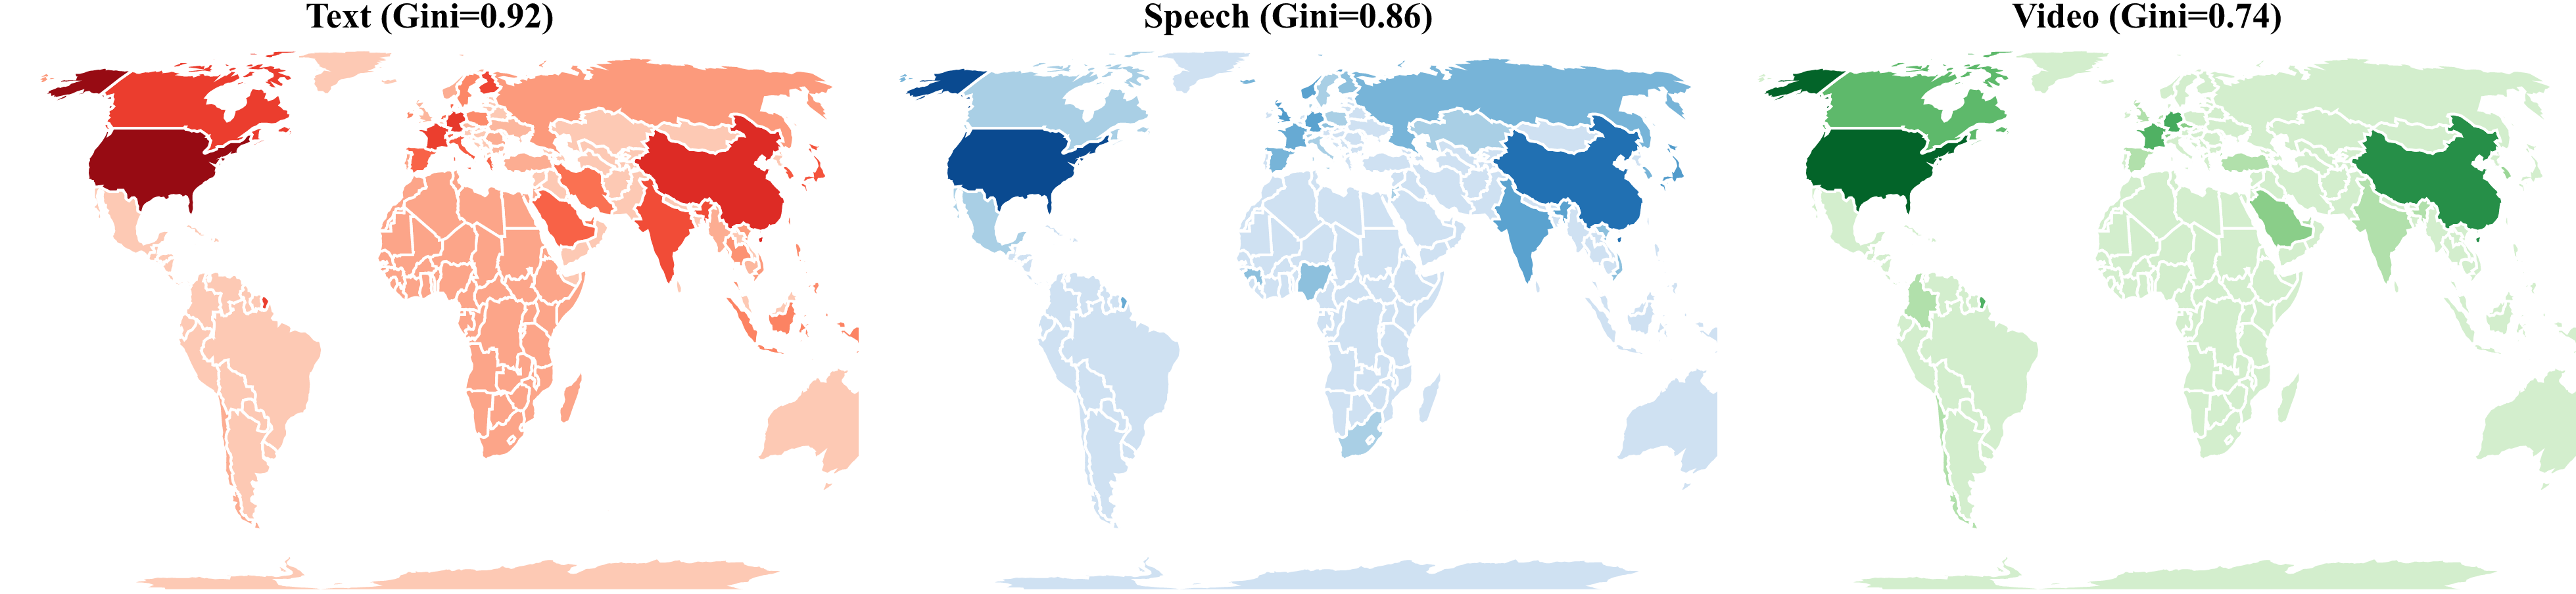

'/Users/shayne/dpi-plotsmultimodal/combined_image.png'

In [16]:
gini_scores = {
    "Text": 0.92,
    "Speech": 0.86,
    "Video": 0.74
}


map_charts = multimodal_util.plot_altair_worldmap_country(
    df,
    data.world_110m.url,
     # World map for plotting
    MODALITY_COLORS,
    CREATORCOUNTRY_PLOTDIM,
    PLOT_DIR,
    gini_scores
)

map_charts

In [ ]:
# map_charts = multimodal_util.plot_altair_worldmap_continent(
#     df,
#     data.world_110m.url, # World map for plotting
#     MODALITY_COLORS,
#     CREATORCOUNTRY_PLOTDIM,
#     PLOT_DIR
# )

# map_charts

In [ ]:
latex1, latex2 = multimodal_util.map_country_to_continent(df)

In [ ]:
print(latex1)

In [ ]:
print(latex2)

## Visualize Data Source Categories by Modality

Distribution of source categories, mapped to higher-level groups in `domain_types.json`, across modalities.

- `df_sources`: DataFrame with grouped sources.

In [ ]:
# Plotting constants
DOMAIN_TYPEMAP = multimodal_util.invert_dict_of_lists(all_constants["DOMAIN_TYPES"])
SOURCECATEGORY_PLOTW = 400
SOURCECATEGORY_PLOTH = 100
SOURCECATEGORY_ORDER = sorted(set(DOMAIN_TYPEMAP.values()) - {"Other"}) + ["Other", "Unspecified"]

In [ ]:
multimodal_util.plot_source_domain_stacked_chart(
    df, DOMAIN_TYPEMAP, SOURCECATEGORY_ORDER, SOURCECATEGORY_PLOTW, SOURCECATEGORY_PLOTH, PLOT_DIR
)

Here, we plot source/domain type distributions by year and modality.

Here, we re-plot the source category distributions, but aggregating within collections for text data (i.e. we use the majority source within collections). For possible ToS mapping (since those annotations are collection level).

In [ ]:
source_chart = multimodal_util.plot_source_domain_stacked_chart_collections(
    df, DOMAIN_TYPEMAP, SOURCECATEGORY_ORDER, SOURCECATEGORY_PLOTW, SOURCECATEGORY_PLOTH, PLOT_DIR
)

source_chart

### Task Categorization

In [ ]:
TASK_TYPEMAP = multimodal_util.invert_dict_of_lists(all_constants["TASK_GROUPS"])
TASKCATEGORY_PLOTW = 280
TASKCATEGORY_PLOTH = 200
TASKCATEGORY_FONT_SIZE = 16
TASKCATEGORY_ORDER = sorted(set(TASK_TYPEMAP.values()) - {"null"})
PLOT_TOFILE_TASKS = True

In [ ]:
speech_task_chart_datasets = multimodal_util.plot_tasks_chart(
    df, TASK_TYPEMAP, TASKCATEGORY_ORDER, TASKCATEGORY_PLOTW, TASKCATEGORY_PLOTH, PLOT_DIR, TASKCATEGORY_FONT_SIZE, "Speech", "Tasks", "Datasets"
)

# speech_task_chart_datasets

In [ ]:
task_chart_text_collections = multimodal_util.plot_tasks_chart(
    # df, TASK_TYPEMAP, TASKCATEGORY_ORDER, TASKCATEGORY_PLOTW, TASKCATEGORY_PLOTH, PLOT_DIR, TASKCATEGORY_FONT_SIZE, "Text", "Task Categories", "Datasets"
    df, TASK_TYPEMAP, TASKCATEGORY_ORDER, TASKCATEGORY_PLOTW, TASKCATEGORY_PLOTH, PLOT_DIR, TASKCATEGORY_FONT_SIZE, "Text", "Task Categories", "Collections"
)

# task_chart_text_collections

In [ ]:
video_task_chart_collections = multimodal_util.plot_tasks_chart(
    df, TASK_TYPEMAP, TASKCATEGORY_ORDER, TASKCATEGORY_PLOTW, TASKCATEGORY_PLOTH, PLOT_DIR, TASKCATEGORY_FONT_SIZE, "Video", "Task Categories", "Datasets"
)

# video_task_chart_collections

In [ ]:
combined_tasks_chart = multimodal_util.concatenate_task_charts(task_chart_text_collections, speech_task_chart_datasets, video_task_chart_collections, 14)

if PLOT_TOFILE_TASKS:
    combined_tasks_chart.save(
        os.path.join(PLOT_DIR, "multimodal-combined_tasks_chart.png"),
        ppi=300
    )

In [ ]:
combined_tasks_chart

### Visualize Dataset dimensions by tokens (Datasets and Collections)
Tokens calculation

#### Datasets split by tokens bins


In [ ]:
# df_tokens.columns

#### Collections split by tokens bins


In [ ]:
# bins_collection = [0, 1000000, 50000000,100000000, 500000000, 1000000000, float('inf')]
# labels_collection = ['0-1M', '1M-50M', '50M-100M', '100M-500M', '500m-1B', '1B+']
text_bins_collection = [0, 1000000, 10000000,100000000, 1000000000, 10000000000, float('inf')]
text_labels_collection = ['0-1M', '1M-10M', '10M-100M', '100M-1B', '1B-10B', '10B+']

# df_tokens = multimodal_util.tokens_calculation(df)
text_collection_chart, text_max_count_collection = multimodal_util.data_aggregation_for_chart(
    df,'Text', text_bins_collection, text_labels_collection, by_collection=True, measure_column='Total Tokens', group_column='Tokens')

speech_bins_collection = [0, 100, 1000,10000, 100000, float('inf')]
speech_labels_collection = ['0-100', '100-1K', '1K-10K', '10K-100K', '100K+']
speech_collection_chart, speech_max_count_collection = multimodal_util.data_aggregation_for_chart(
    df,'Speech', speech_bins_collection, speech_labels_collection, by_collection=False, measure_column='Hours', group_column='Hours')

video_bins_collection = [0, 100, 1000,10000, 100000, float('inf')]
video_labels_collection = ['0-100', '100-1K', '1K-10K', '10K-100K', '100K+']
video_collection_chart, video_max_count_collection = multimodal_util.data_aggregation_for_chart(
    df,'Video', speech_bins_collection, speech_labels_collection, by_collection=False, measure_column='Hours', group_column='Hours')

#### Combine graphs for dataset and collections split


In [ ]:
# chart1 = multimodal_util.chart_creation(
#     dataset_chart, 
#     max_count_dataset, 
#     x_field='Token Groups',  
#     labels=labels_dataset,
#     ratio=1.15,
#     title='Token distributions by Datasets',
#     width=400,
#     height=300,
#     color='skyblue'
# )

DIM_CHART_WIDTH = 300
DIM_CHART_HEIGHT = 200


text_dim_chart = multimodal_util.chart_creation(
    text_collection_chart, 
    text_max_count_collection, 
    x_field='Tokens',  
    labels=text_labels_collection,
    ratio=1.15,
    title='Text (Tokens)',
    width=DIM_CHART_WIDTH,
    height=DIM_CHART_HEIGHT,
    color='salmon'
)

speech_dim_chart = multimodal_util.chart_creation(
    speech_collection_chart, 
    speech_max_count_collection, 
    x_field='Hours',  
    labels=speech_labels_collection,
    ratio=1.15,
    title='Speech (Hours)',
    width=DIM_CHART_WIDTH,
    height=DIM_CHART_HEIGHT,
    color='skyblue'
)

video_dim_chart = multimodal_util.chart_creation(
    video_collection_chart, 
    video_max_count_collection, 
    x_field='Hours',  
    labels=video_labels_collection,
    ratio=1.15,
    title='Video (Hours)',
    width=DIM_CHART_WIDTH,
    height=DIM_CHART_HEIGHT,
    color='forestgreen'
)


# Concatenate the two charts horizontally with different scales for the y-axes
combined_chart = multimodal_util.combined_dim_charts(text_dim_chart, speech_dim_chart, video_dim_chart)
combined_chart = combined_chart.configure_view(strokeOpacity=0)

# Save the plot if PLOT_TOFILE is True
if PLOT_TOFILE:
    output_file = os.path.join(PLOT_DIR, "Token_&_collection.png")
    combined_chart.save(output_file, scale_factor=PLOT_PPI/100)

# Display the chart
combined_chart.display()

In [ ]:
# df.columns

### Source Categories by Hours/Tokens

In [ ]:
INCLUDE_TOP_N_CATEGORIES = 12
SRC_CAT_CUMULATIVE_PLOTW = 380
SRC_CAT_CUMULATIVE_PLOTH = 190
EARLIEST_YEAR = 2013

In [ ]:
speech_chart_sourceyearhours = multimodal_util.plot_temporal_cumulative_sources(
    df, "Speech", INCLUDE_TOP_N_CATEGORIES, "Hours", EARLIEST_YEAR, SRC_CAT_CUMULATIVE_PLOTW, SRC_CAT_CUMULATIVE_PLOTH)

In [ ]:
video_chart_sourceyearhours = multimodal_util.plot_temporal_cumulative_sources(
    df, "Video", INCLUDE_TOP_N_CATEGORIES, "Hours", EARLIEST_YEAR, SRC_CAT_CUMULATIVE_PLOTW, SRC_CAT_CUMULATIVE_PLOTH)

In [ ]:
text_chart_sourceyearhours = multimodal_util.plot_temporal_cumulative_sources(
    df, "Text", 13, "Total Tokens", EARLIEST_YEAR, SRC_CAT_CUMULATIVE_PLOTW, SRC_CAT_CUMULATIVE_PLOTH)

In [ ]:
combined_cumulative_source_chart = multimodal_util.combined_dim_charts(text_chart_sourceyearhours, speech_chart_sourceyearhours, video_chart_sourceyearhours)

In [ ]:
def post_process_combined_chart(hconchart):
    return hconchart.configure_axis(
        grid=False,
        labelFontSize=13,
        titleFontSize=15
    ).configure_axisX(
        labelExpr="datum.value == '<2013' || datum.value == '2014' || (year(datum.value) % 2 == 1 && datum.value != '<2013' && datum.value != '2014') ? datum.label : ''",
        labelAngle=0
    ).configure_view(
        stroke=None
    )


combined_cumulative_source_chart = post_process_combined_chart(combined_cumulative_source_chart)

In [ ]:
combined_cumulative_source_chart

## Gini Coefficient Across Languages by (Cumulative) Total Hours

In [23]:
df_textlanguagesfamilycumulativehoursgini, df_text_lang_explode = multimodal_util.prep_text_for_lang_gini(df, all_constants)
df_textlanguagesfamilycumulativehoursgini['Type'] = 'Text ' + df_textlanguagesfamilycumulativehoursgini['Type']
df_text_lang_explode['Modality'] = 'Text'
df_speechlanguagesfamilycumulativehoursgini, df_speechlanguagesn = multimodal_util.prepare_speech_for_gini(df)
df_speechlanguagesfamilycumulativehoursgini['Type'] = 'Speech ' + df_speechlanguagesfamilycumulativehoursgini['Type']
df_speechlanguagesn['Modality'] = 'Speech'
df_speech_text_gini = pd.concat([df_textlanguagesfamilycumulativehoursgini,df_speechlanguagesfamilycumulativehoursgini])
df_speech_text_spec = pd.concat([df_text_lang_explode,df_speechlanguagesn])
lang_gini_chart = multimodal_util.plot_temporal_ginis(df_speech_text_gini, df_speech_text_spec, ["Language (ISO)", "Language Family"], columns=2)

Text | Language (ISO) | 509
Text | Language Family | 21
Speech | Language (ISO) | 276
Speech | Language Family | 36


In [29]:
df_text_lang_explode

,Collection,Dataset Name,Year Released Category,Tokens,Languages,Language Families,Language (ISO),Language Family,Modality
0,PMC-LLaMA Instructions,liveqa,2023,1450519.934,English,English,eng,Indo-European,Text
1,PMC-LLaMA Instructions,medicationqa,2023,632781.998,English,English,eng,Indo-European,Text
2,PMC-LLaMA Instructions,medmcqa,2023,315971372.293,English,English,eng,Indo-European,Text
3,PMC-LLaMA Instructions,medqa_train,2023,81397268.142,English,English,eng,Indo-European,Text
4,PMC-LLaMA Instructions,pubmedqa,2019,834909525.145,English,English,eng,Indo-European,Text
...,...,...,...,...,...,...,...,...,...
3712,CoT Collection,cotcollection_zh,2023,41412022.229,Code,Code,Code,Code,Text
3713,ExpertQA,expert_qa,2023,3869296.076,English,English,eng,Indo-European,Text
3714,Flan Collection (Dialog),qrecc,2020,110805042.487,English,English,eng,Indo-European,Text
3715,Flan Collection (Dialog),wiki_dialog,2022,1884678815.927,English,English,eng,Indo-European,Text


In [ ]:
df_gini_locs, df_spec_locs = multimodal_util.prepare_geo_gini_data(df)
geo_gini_chart = multimodal_util.plot_temporal_ginis(df_gini_locs, df_spec_locs, ["Countries"], columns=4)

In [ ]:
df_spec_src = multimodal_util.prepare_data_cum_barchart(df_spec_locs, "Countries")
geo_barchart = multimodal_util.plot_cum_barchart(df_spec_src, "Countries", domains=["Video", "Speech", "Text"])

In [ ]:
df_spec_src_lang = multimodal_util.prepare_data_cum_barchart(df_speech_text_spec, "Language (ISO)")
lang_barchart = multimodal_util.plot_cum_barchart(df_spec_src_lang, "Language (ISO)", domains=["Speech", "Text"])

In [ ]:
geo_barchart

In [ ]:
lang_barchart

In [ ]:
geo_gini_chart

In [ ]:
lang_gini_chart

In [ ]:
# df_spec_src_lang

In [ ]:
# df.columns

In [ ]:
df_text = df[df["Modality"] == "Text"]
df_text["Source"] = df_text["Text Sources"]
df_speech = df[df["Modality"] == "Speech"]
df_speech["Task Categories"] = df_speech["Tasks"]
df_video = df[df["Modality"] == "Video"]
df_video["Source"] = df_video["Source Category"]
df_mod_merged = pd.concat([df_text, df_speech, df_video])
# df_text_speech_merged = pd.concat([df_text, df_speech])

# \textsc{Modality} & \multicolumn{2}{c}{\textsc{Dimensions}} & \multicolumn{2}{c}{\textsc{Sources}} & \multicolumn{2}{c}{\textsc{Tasks}} 
# & \multicolumn{2}{c}{\textsc{Creators}} & \multicolumn{2}{c}{\textsc{Languages}} & \textsc{Licenses}  \\
 # & \textsc{Datasets} & \textsc{|Size|} & \textsc{|Unique|} & \textsc{Domains} & \textsc{|Unique|} & \textsc{Categories} & \textsc{|Unique|} & \textsc{Countries} & \textsc{|Unique|} & \textsc{|Families|} & \textsc{|Unique|} \\

# Dimensions, Sources, Tasks, Creators, Licenses
# Year Released? 
def unpack_key_stats(df_spec, sum_col, task_col, src_col):
    df_spec['License Resolved'] = df_spec['Licenses'].apply(lambda x: [d['License'] for d in x])
    return {
        "Num Datasets": len(df_spec),
        "Total Size": df_spec[sum_col].sum(),
        "Mean Size": df_spec[sum_col].sum() / len(df_spec),
        "Unique Creators": df_spec.explode("Creators")["Creators"].nunique(),
        "Countries": df_spec.explode("Countries")["Countries"].nunique(),
        "Sources": df_spec.explode(src_col)[src_col].nunique(),
        "Source Categories": df_spec.explode("Source Category")["Source Category"].nunique(),
        "Task Categories": df_spec.explode(task_col)[task_col].nunique(),
        "Unique Licenses": df_spec.explode("License Resolved")["License Resolved"].nunique(),
    }

def unpack_total_stats(df_spec):
    df_spec['License Resolved'] = df_spec['Licenses'].apply(lambda x: [d['License'] for d in x])
    return {
        "Num Datasets": len(df_spec),
        # "Total Size": df_spec[sum_col].sum(),
        # "Mean Size": df_spec[sum_col].sum() / len(df_spec),
        "Unique Creators": df_spec.explode("Creators")["Creators"].nunique(),
        "Countries": df_spec.explode("Countries")["Countries"].nunique(),
        "Sources": df_spec.explode("Source")["Source"].nunique(),
        "Source Categories": df_spec.explode("Source Category")["Source Category"].nunique(),
        "Task Categories": df_spec.explode("Task Categories")["Task Categories"].nunique(),
        "Unique Licenses": df_spec.explode("License Resolved")["License Resolved"].nunique(),
    }

In [ ]:
unpack_key_stats(df_video, "Hours", "Task Categories", "Source Category")

In [ ]:
unpack_key_stats(df_speech, "Hours", "Task Categories", "Source")

In [ ]:
unpack_key_stats(df_text, "Total Tokens", "Task Categories", "Text Sources")

In [ ]:
unpack_total_stats(df_mod_merged)

In [ ]:
print(df_speech_text_spec["Language (ISO)"].nunique())
print(df_speech_text_spec["Language Family"].nunique())
# df_text_speech_merged["Language Families"]

In [ ]:
len(df)

In [ ]:
# df_speech_text_spec[df_speech_text_spec["Modality"] == "Speech"]["Language (ISO)"].unique()
df_speech_text_spec["Language (ISO)"].unique()

In [ ]:
import langcodes

In [ ]:
all_lang_codes = df_speech_text_spec["Language (ISO)"].unique()

In [ ]:
df_text_langs = df_speech_text_spec[df_speech_text_spec["Modality"] == "Text"]["Language (ISO)"].unique()
df_speech_langs = df_speech_text_spec[df_speech_text_spec["Modality"] == "Speech"]["Language (ISO)"].unique()

In [ ]:
def is_human_language(code):
    try:
        lang = langcodes.Language.get(code)

        # Ensure it's a valid language code and not a fallback
        return lang.is_valid()
    except Exception:
        return False

def dedup_langs(vals):
    natlangs, proglangs = set(), set()
    for val in vals:
        if is_human_language(val):
            natlangs.add(langcodes.Language.get(val).language)
        else:
            proglangs.add(val)

    natlangs = sorted(natlangs)
    proglangs = sorted(proglangs)

    natlang_names = [
        langcodes.Language.get(v).display_name()
        for v in natlangs
    ]

    assert len(natlang_names) == len(set(natlang_names))

    # print(f'Natural Languages ({len(natlangs)}): {natlangs}')
    print(f'Natural Languages ({len(natlangs)})')
    # print()
    # print(f'Natural Language Names: {natlang_names}')
    # print()
    # print(f'Programming Languages ({len(proglangs)}): {proglangs}')
    print(f'Programming Languages ({len(proglangs)})')
    print(f"Sum: {len(natlangs) + len(proglangs)}")

In [ ]:
dedup_langs(all_lang_codes)

In [ ]:
dedup_langs(df_text_langs)

In [ ]:
dedup_langs(df_speech_langs)